# Imports

In [61]:
from os import path, listdir
from copy import deepcopy
import stlearn as st
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import cv2

%load_ext autoreload
%autoreload 2

from scanpy_stlearn_loaders import StlearnLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data 

In [62]:
dataset_name = 'Visium_Mouse_Olfactory_Bulb'

## Genes-Spots Expression Values 

In [63]:
obj = StlearnLoader().load_local_visum(path=path.join('/', 'data', dataset_name),
                                      count_file='filtered_feature_bc_matrix.h5')
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')
obj

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# spots: 1185 | # genes: 32285


AnnData object with n_obs × n_vars = 1185 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Spatial Images 

In [ ]:
# Low resolution Images
spatial_dir = path.join('/', 'data', dataset_name, 'spatial')
for img in [k for k in listdir(spatial_dir) if k.endswith('.jpg') or k.endswith('.png')]:
    plt.title(img)
    plt.imshow(cv2.imread(path.join(spatial_dir, img)))
    plt.show()
    
print('Spots:')
display(obj.obs.head())

## Full Resolution Image 

In [ ]:
# Full Resultion Image

from PIL import Image
image_path = path.join('/', 'data', dataset_name, 'image.tif')
im = Image.open(image_path)
image_array = np.array(im)
im.show()

## Kmeans Clustering

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


Text(0.5, 1.0, 'Raw Data')

<Figure size 432x288 with 0 Axes>

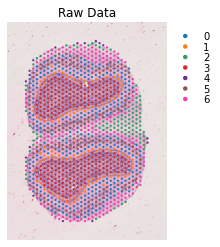

In [64]:
st.pp.normalize_total(obj)
st.pp.log1p(obj)
# run PCA for gene expression data
st.em.run_pca(obj, n_comps=50)
# K-means clustering
st.tl.clustering.kmeans(obj, n_clusters=7, use_data="X_pca", key_added="X_pca_kmeans")

f = plt.figure()
st.pl.cluster_plot(obj, use_label="X_pca_kmeans")
plt.title('Raw Data')

# Filter Genes
- min_cells = Keep genes with at least X spots with non zero expression (x[spot, gene] > 0)
- min_counts = Keep genes with at least X expressions (sum of expression over all spots) (sum(x[:, gene]) > X)

In [88]:
obj = StlearnLoader().load_local_visum(path=path.join('/', 'data', dataset_name),
                                      count_file='filtered_feature_bc_matrix.h5')

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [95]:
# Keep genes with at least 98.5% non zero spots
min_cells = int(n_spots * 0.985)
print(f'Keep genes with at least {min_cells} non zero spots')
st.pp.filter_genes(obj, min_cells=min_cells)
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')

Keep genes with at least 1167 non zero spots
# spots: 1185 | # genes: 96


In [96]:
min_counts = 10
print(f'Keep genes with total expression of at least {min_counts} over all spots')
st.pp.filter_genes(obj, min_counts=min_counts)
x = obj.X.toarray()
n_spots, n_genes = x.shape
print(f'# spots: {n_spots} | # genes: {n_genes}')

Keep genes with total expression of at least 10 over all spots
# spots: 1185 | # genes: 96


## Filtered Kmeans Clustering

In [97]:
st.pp.normalize_total(obj)
st.pp.log1p(obj)
# run PCA for gene expression data
st.em.run_pca(obj, n_comps=50)
# K-means clustering
st.tl.clustering.kmeans(obj, n_clusters=7, use_data="X_pca", key_added="X_pca_kmeans")

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


In [102]:
colors_map_dict = {
    '#1f77b4': 1, # Blue
    '#f87f13': 3, # Orange
    '#359c62': 6, # Green
    '#d32929': 0, # Red
    '#69308e': 4, # Purple
    '#8c564c': 2, # Brown
    '#f33ca9': 5  # Pink
}
clusters_colors = [c[0] for c in sorted(colors_map_dict.items(), key=lambda i: i[1])]

In [103]:
obj.uns['X_pca_kmeans_colors'] = clusters_colors

Text(0.5, 1.0, 'Filtered Data')

<Figure size 432x288 with 0 Axes>

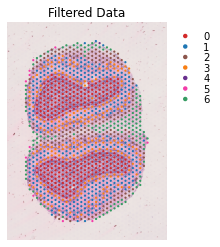

In [104]:
f = plt.figure()
st.pl.cluster_plot(obj, use_label="X_pca_kmeans")
plt.title('Filtered Data')

# EDA 

## Genes - Spots Info

In [ ]:
print('Spots information')
display(obj.obs.head())
print('Genes information')
display(obj.var.head())

In [ ]:
print(f'All the spots in the matrix are in the tissue: "in_tissue" # unique values = {obj.obs.in_tissue.nunique()}')
print(f'All the genes are from the same genome: "genome" # unique values = {obj.var.genome.nunique()}')

## Expression over spots 

In [ ]:
def total_exp_over_spots(x):
    plt.figure(figsize=(15, 6))
    spots_total_exp = x.sum(axis=1)
    sns.histplot(spots_total_exp)
    plt.title('Total expression in spots (Histogram)')
    plt.xlabel('Total Expression')
    plt.ylabel('# of spots')
    plt.show()

In [ ]:
total_exp_over_spots(x)

In [ ]:
def spots_sparsity(x):
    plt.figure(figsize=(15, 6))
    spots_exp_sparsity = (x.shape[1] - np.count_nonzero(x, axis=1)) / x.shape[1]
    sns.histplot(spots_exp_sparsity)
    plt.title('Spots Expression Sparsity (Histogram)')
    plt.xlabel('% Sparsity (% of genes with zero expression)')
    plt.ylabel('# of spots')
    plt.show()

In [ ]:
spots_sparsity(x)

## Expression over genes

In [ ]:
def total_exp_over_genes(x, logx=True, logy=True):
    plt.figure(figsize=(15, 6))
    genes_total_exp = x.sum(axis=0)
    sns.histplot(genes_total_exp)
    plt.title('Total expression in genes (Histogram)')
    plt.xlabel('Total Expression')
    plt.ylabel('# of genes')
    if logy:
        plt.yscale('log')
    if logx:
        plt.xscale('log')
    plt.show()

In [ ]:
total_exp_over_genes(x)

In [ ]:
def genes_sparsity(x):
    plt.figure(figsize=(15, 6))
    genes_exp_sparsity = (x.shape[0] - np.count_nonzero(x, axis=0)) / x.shape[0]
    sns.histplot(genes_exp_sparsity)
    plt.title('Genes Expression Sparsity (Histogram)')
    plt.xlabel('% Sparsity (% of spots with zero expression)')
    plt.ylabel('# of genes')
    plt.show()

In [ ]:
genes_sparsity(x)

## Unstructred 

In [ ]:
obj_unstructred = obj.uns['spatial']['Visium_Mouse_Olfactory_Bulb']

In [ ]:
print(f"Scale factors: \n{obj_unstructred['scalefactors']}")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 8))
ax1.imshow(obj_unstructred['images']['hires'])
ax1.set_title('Hires Image')
ax2.imshow(obj_unstructred['images']['lowres'])
ax2.set_title('Lowres Image')
plt.show()

## Genes Expressions 

### Top N Expressed Genes 

In [ ]:
N = 10
genes_expressed = np.sum(x, axis=0) / (np.count_nonzero(x, axis=0) + 1)
top_genes_indices = genes_expressed.argsort()[-N:][::-1]
top_genes_names = obj.var.index[top_genes_indices]
print(top_genes_names)
top_genes_expression = x[:, top_genes_indices]
top_genes_expression.shape

In [ ]:
tmp = pd.DataFrame(top_genes_expression, columns=top_genes_names)
tmp.plot.box(figsize=(15, 9), title='Top expressed genes', rot=90)
plt.show()

In [ ]:
for gene_symbol in top_genes_names:
    st.pl.gene_plot(obj, gene_symbols=gene_symbol, size=20, figsize=(12, 9))
    plt.show()

## Log expression 

In [ ]:
st.pp.log1p(obj)
scaled_x = obj.X.toarray()
obj

In [ ]:
total_exp_over_spots(scaled_x)
total_exp_over_genes(scaled_x, logx=False, logy=False)